Consolidate the folds into a single set of results.

In particular, compute the mean and standard deviations of the models in the accuracy, recall and F-score. 

In [1]:
import os
from glob import glob

import numpy as np
import tensorflow as tf

import ScalableLib.classifier.Multiband as multiband
import ScalableLib.base.plot as plot


2024-08-29 13:01:54.251601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 13:01:54.251641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 13:01:54.252816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 13:01:54.259713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 13:01:55.166858: W tensorflow/compiler/tf2

In [2]:
# To reset cuda
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm
# To see if the system regognises the GPU
device = 1
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[device], 'GPU')
tf.config.experimental.set_memory_growth(device=devices[device], enable=True)


Read the Results folder.

In [4]:
survey = 'PanStarrs'
path = os.path.join('../../03_TrainModels/', survey, 'Results/Fold_*',)
folds = glob(path)
folds.sort()
folds

['../../03_TrainModels/PanStarrs/Results/Fold_1',
 '../../03_TrainModels/PanStarrs/Results/Fold_2',
 '../../03_TrainModels/PanStarrs/Results/Fold_3',
 '../../03_TrainModels/PanStarrs/Results/Fold_4',
 '../../03_TrainModels/PanStarrs/Results/Fold_5',
 '../../03_TrainModels/PanStarrs/Results/Fold_6',
 '../../03_TrainModels/PanStarrs/Results/Fold_7']

In [5]:
folder_name = 'Results'
path = os.path.join('.', folder_name,'')
if not os.path.exists(path):
    os.mkdir(path)

For each fold, read the models and evaluate on the test set. Save the results

In [6]:
label_order = ['MIRA_SR', 'T2CEP', 'RRAB', 'RRC', 'RRD', 'DSCT_SXPHE']

In [7]:
# Containers to store the results
reports_folds = []
cm_folds = []
for fold in folds:
    tf.keras.backend.clear_session()
    # Set the fold path
    base_dir = fold+'/'
    
    # Get the last run
    path_runs_folder = os.path.join(base_dir, 'Models', '*')
    path_runs = glob(path_runs_folder)
    path_runs.sort()
    path_run = path_runs[-1]    
    
    path_preprocess = fold.replace('/03_TrainModels/', '/02_CreateRecords/').replace('/Results/', '/Folds/')
    test_files = os.path.join(path_preprocess, 'test/*.tfrecord')
    path_preprocess = os.path.join(path_preprocess, 'metadata_preprocess.json')    

    
    new = multiband.Network()    
    settings_path = os.path.join(path_run, 'all_settings.json')

    fold_name = fold.split('/')[-1]
    write_path = os.path.join('./Results', fold_name+'_Results.dat')
    
    # Get weights path
    run = path_run.split('/')[-1]
    weights_path = os.path.join(fold, 'Models', run)
    new.run_test(settings_path, test_files, weights_path, df_paths = write_path);
    # break
    result_path = os.path.join('./Results', fold.split('/')[-1]+'_Results.dat')
    
    # From the results file, read the data and compute the classification scores
    report_fold = plot.compute_classification_report(result_path)
    reports_folds.append(report_fold)
    # From the results file, read the data and compute the confussion matrix and the respective  labels 
    cm_fold = plot.compute_confussion_matrices(result_path, labels=label_order)
    cm_folds.append(cm_fold)


2024-08-29 13:02:27.144221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9424 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


../../02_CreateRecords/PanStarrs/Folds/Fold_1/test/*.tfrecord


2024-08-29 13:02:28.343325: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-29 13:02:58.437581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


              precision    recall  f1-score   support

  DSCT_SXPHE       0.77      0.67      0.72       381
     MIRA_SR       0.97      0.92      0.94       788
        RRAB       0.75      0.82      0.78      2000
         RRC       0.78      0.72      0.75      2000
         RRD       0.02      0.06      0.03        53
       T2CEP       0.43      0.32      0.36        38

    accuracy                           0.77      5260
   macro avg       0.62      0.58      0.60      5260
weighted avg       0.79      0.77      0.78      5260

../../02_CreateRecords/PanStarrs/Folds/Fold_2/test/*.tfrecord
              precision    recall  f1-score   support

  DSCT_SXPHE       0.72      0.56      0.63       381
     MIRA_SR       0.97      0.92      0.95       788
        RRAB       0.74      0.80      0.77      2000
         RRC       0.77      0.72      0.74      2000
         RRD       0.03      0.08      0.04        53
       T2CEP       0.45      0.39      0.42        38

    accuracy   

In [8]:
statistic = 'mean'
mean, std = plot.obtain_accumulated_metrics(reports_folds, metric=statistic, label_order=label_order)
display(mean)
display(std)

,MIRA_SR,T2CEP,RRAB,RRC,RRD,DSCT_SXPHE
precision,0.97,0.43,0.76,0.78,0.04,0.75
recall,0.93,0.31,0.80,0.73,0.11,0.64
f1-score,0.95,0.36,0.78,0.76,0.06,0.69
support,788.00,38.00,2000.00,2000.00,53.00,381.00


,MIRA_SR,T2CEP,RRAB,RRC,RRD,DSCT_SXPHE
precision,0.005983,0.065109,0.016389,0.010293,0.014102,0.027590
recall,0.009793,0.057014,0.012898,0.023617,0.053094,0.052193
f1-score,0.004250,0.057514,0.006983,0.011446,0.022031,0.032822
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Figure size 640x480 with 0 Axes>

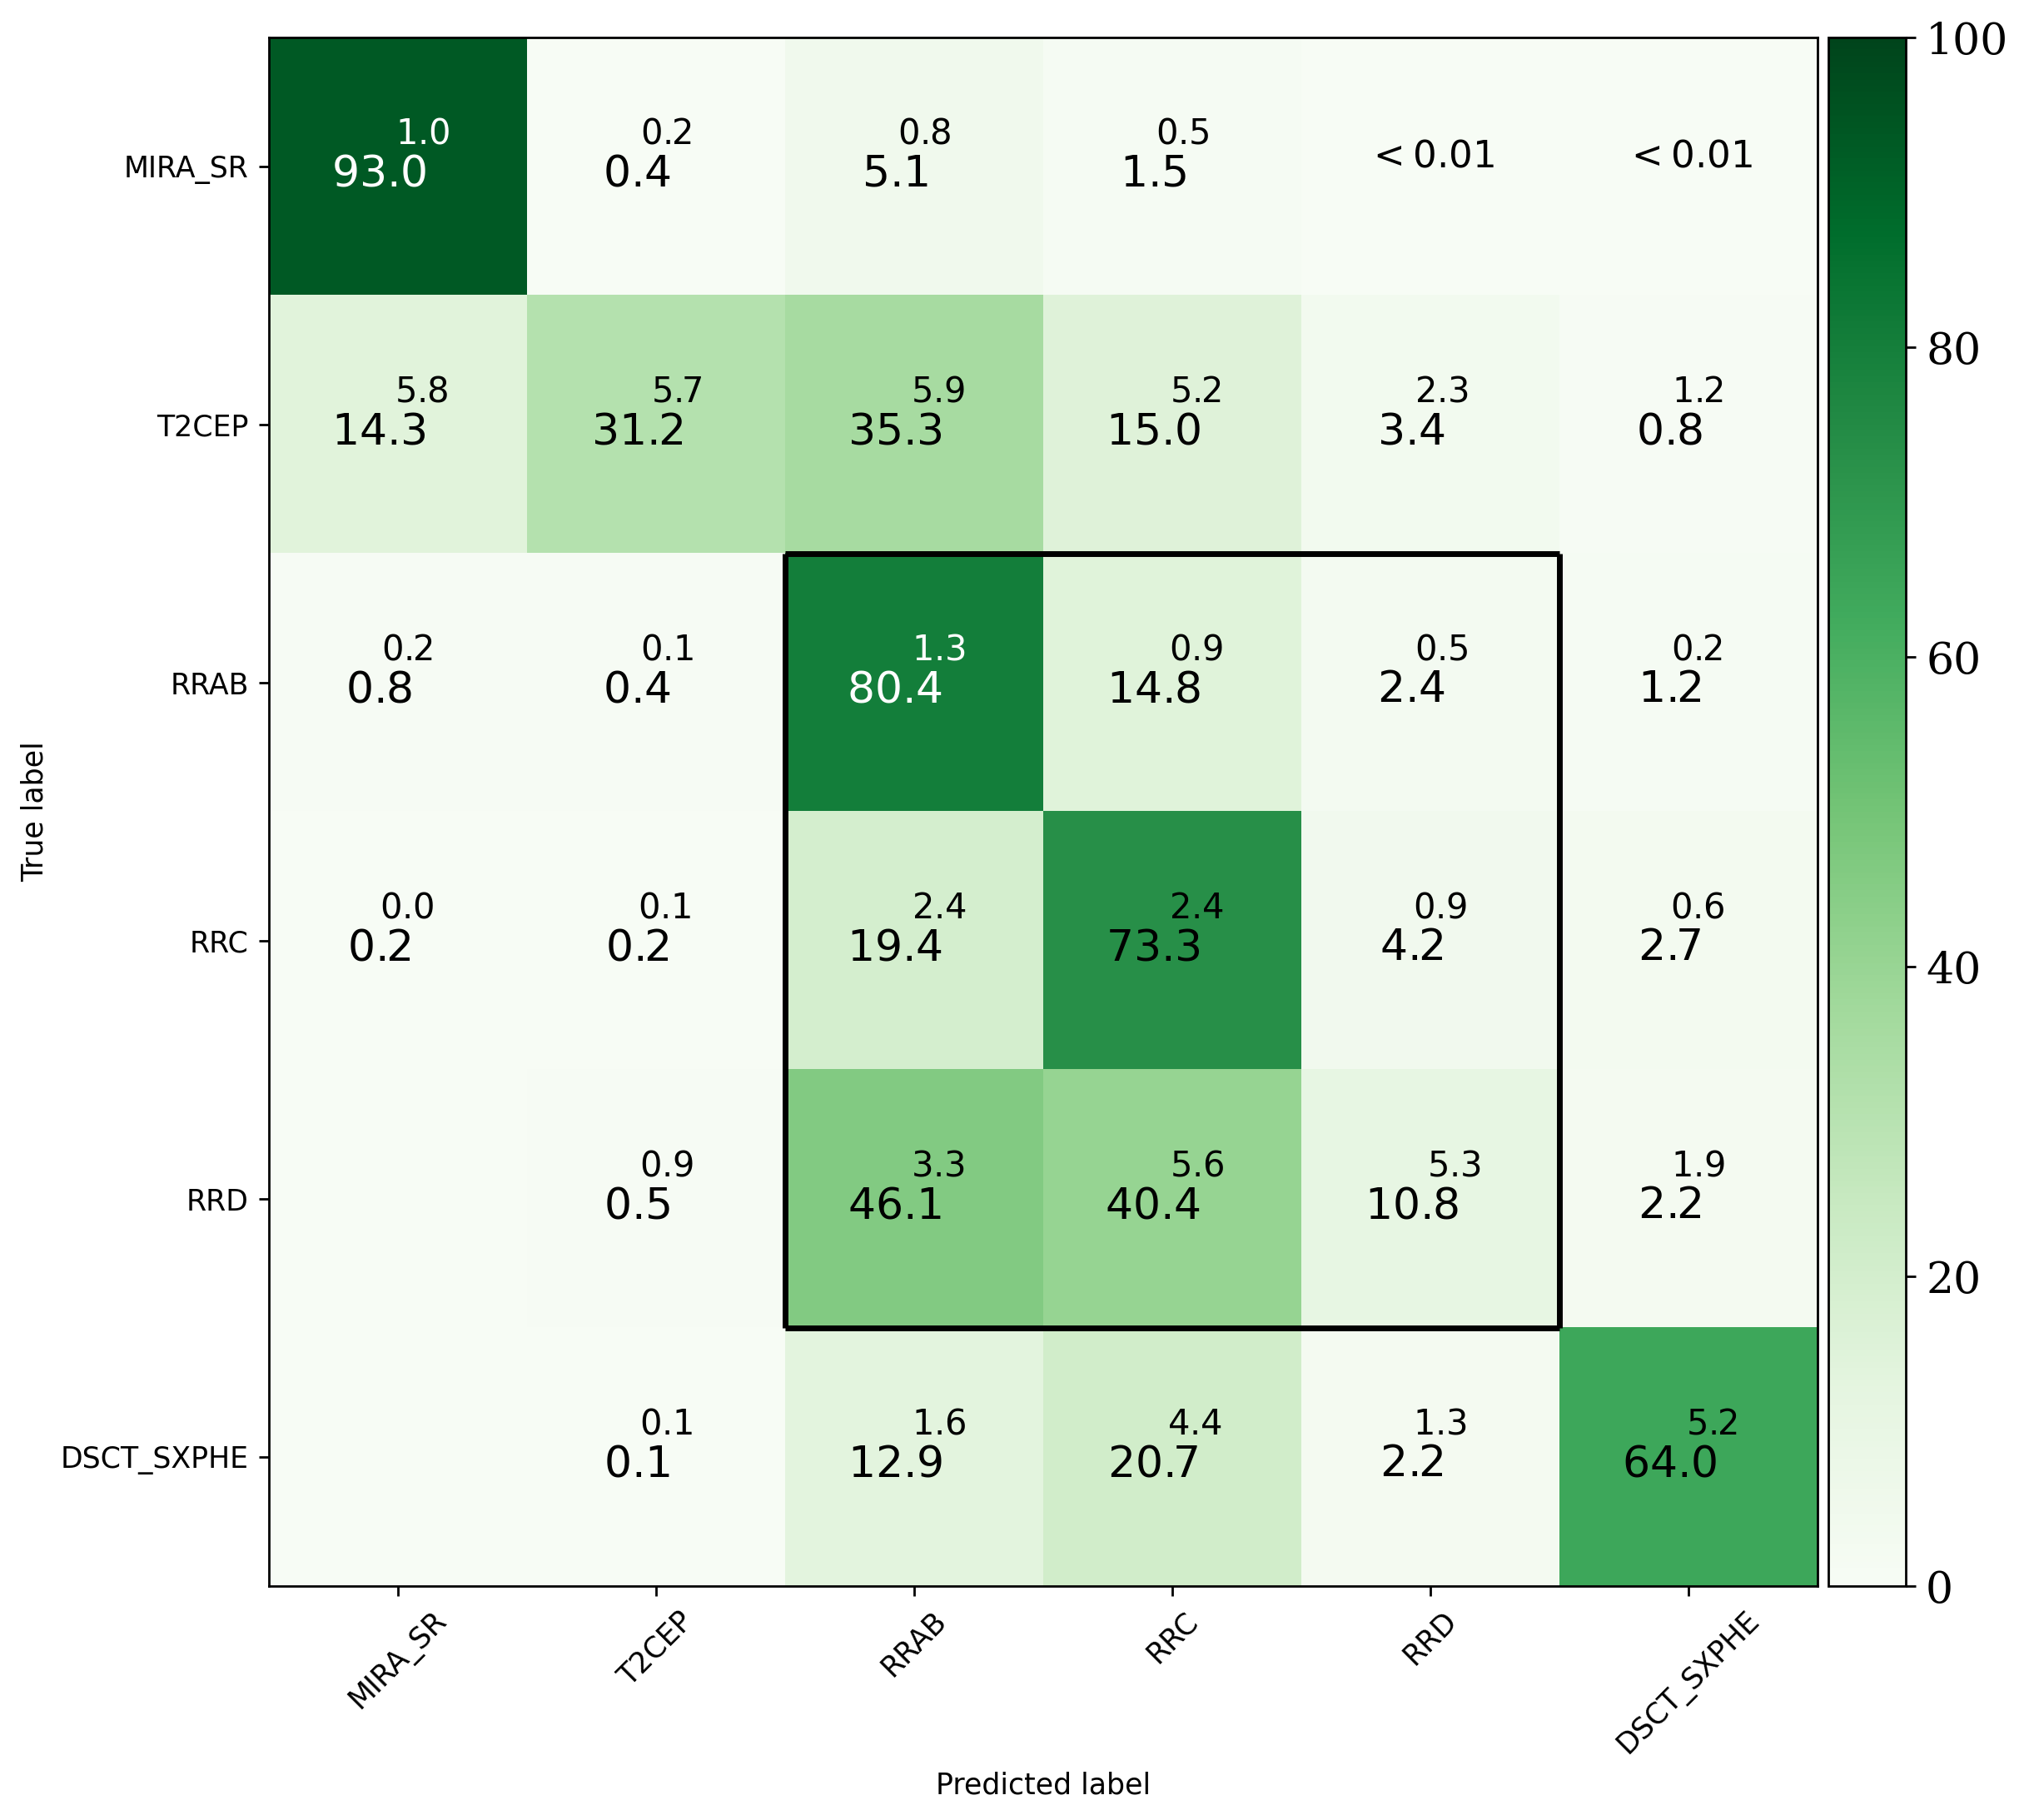

In [9]:
img_path = './'+survey+'_'+statistic+'_c.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey='PanStarrs', statistic=statistic, save_path=img_path)

In [10]:
statistic = 'median'
median, delta_up, delta_down = plot.obtain_accumulated_metrics(reports_folds, metric=statistic, label_order=label_order)
display(median)
display(delta_up)
display(delta_down)

,MIRA_SR,T2CEP,RRAB,RRC,RRD,DSCT_SXPHE
precision,0.97,0.45,0.76,0.78,0.04,0.77
recall,0.93,0.32,0.80,0.73,0.09,0.67
f1-score,0.95,0.36,0.78,0.75,0.06,0.70
support,788.00,38.00,2000.00,2000.00,53.00,381.00


,MIRA_SR,T2CEP,RRAB,RRC,RRD,DSCT_SXPHE
precision,0.000689,0.018127,0.017079,0.006242,0.005948,0.007395
recall,0.009518,0.039474,0.011000,0.010500,0.056604,0.010499
f1-score,0.003791,0.041661,0.003278,0.009285,0.014625,0.015119
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,MIRA_SR,T2CEP,RRAB,RRC,RRD,DSCT_SXPHE
precision,0.001526,0.046490,0.013571,0.008267,0.018625,0.033125
recall,0.003807,0.052632,0.012250,0.008000,0.028302,0.055118
f1-score,0.001501,0.038147,0.004348,0.006688,0.023521,0.024617
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
np.round(median.loc['f1-score'].mean(),3)

0.6

<Figure size 640x480 with 0 Axes>

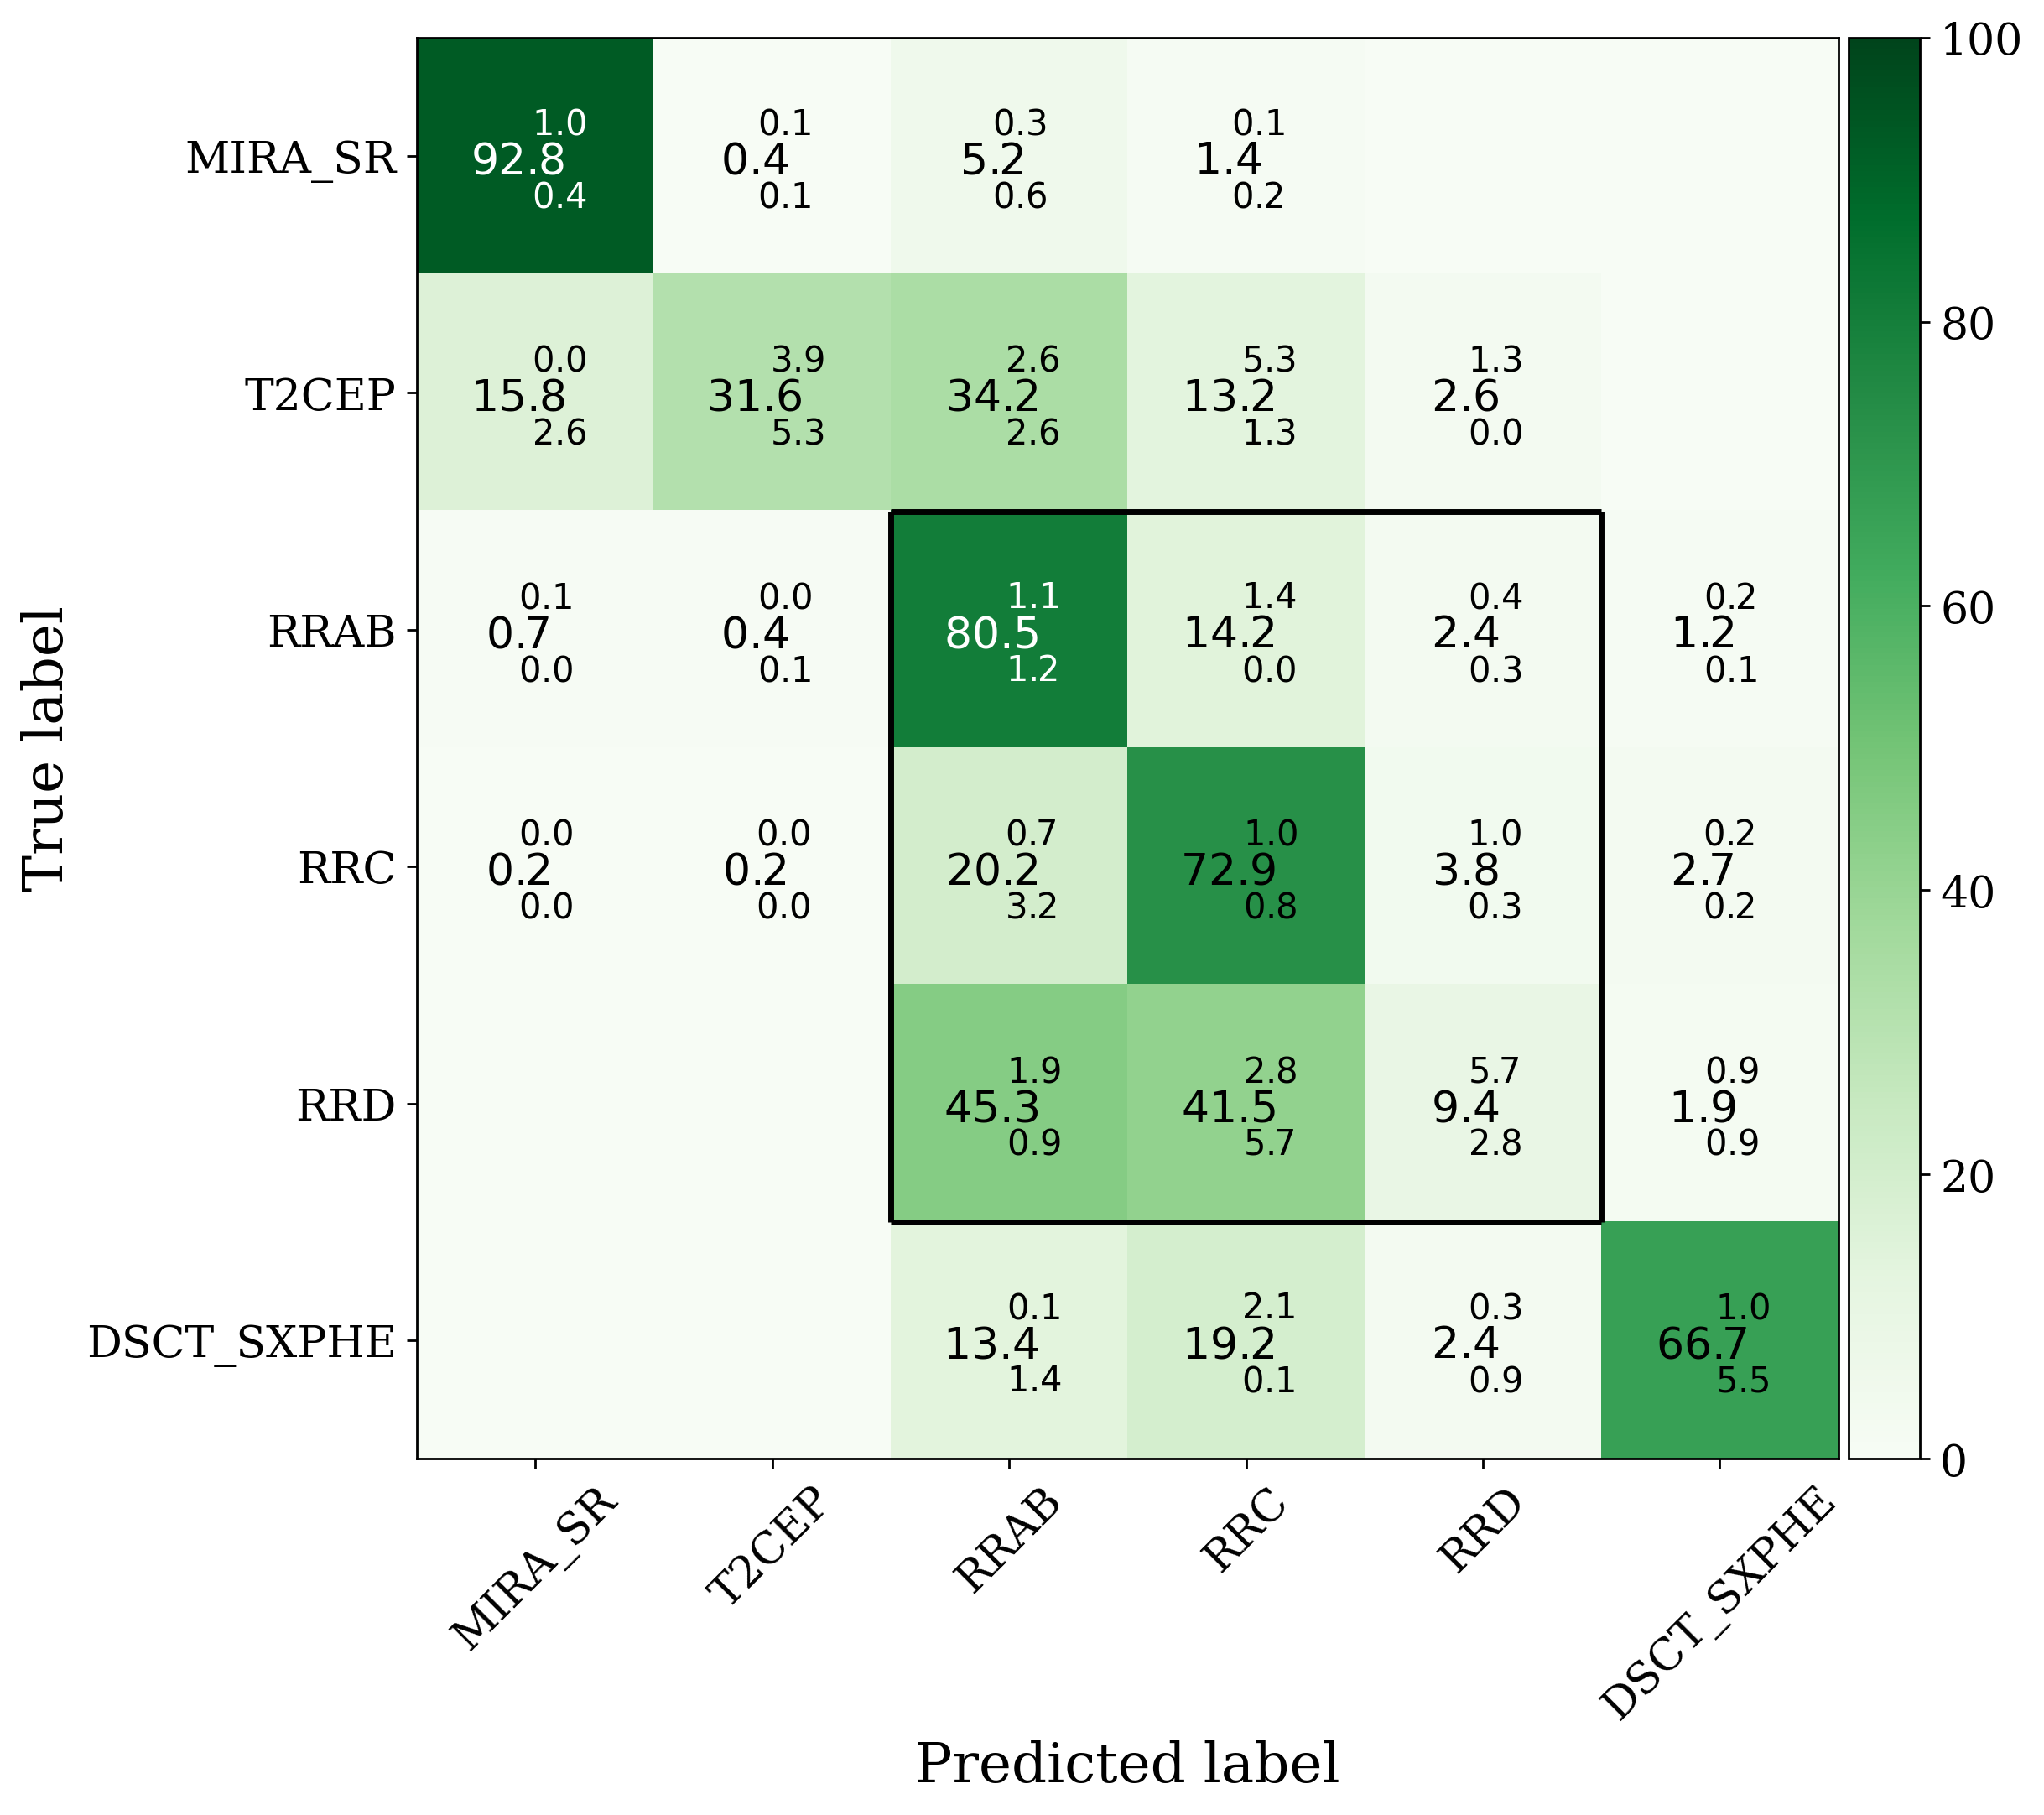

In [13]:
img_path = './'+survey+'_'+statistic+'_c.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey='PanStarrs', statistic=statistic, save_path=img_path)

In [14]:
accuracies = [reports_folds[i]['accuracy'] for i in range(len(reports_folds))]
np.round(np.median(accuracies),4), np.round(np.mean(accuracies),4)


(0.7734, 0.7735)

In [15]:
macro_avg_recall = [reports_folds[i]['macro avg']['recall'] for i in range(len(reports_folds))]
np.round(np.median(macro_avg_recall),4), np.round(np.mean(macro_avg_recall),4)

(0.5893, 0.5879)

Macro metrics

Accuracy

In [16]:
accuracies = [reports_folds[i]['accuracy'] for i in range(len(reports_folds))]
np.round(np.median(accuracies),4), np.round(np.mean(accuracies),4)


(0.7734, 0.7735)

Macro-avg recall

In [17]:
macro_avg_recall = [reports_folds[i]['macro avg']['recall'] for i in range(len(reports_folds))]
np.round(np.median(macro_avg_recall),4), np.round(np.mean(macro_avg_recall),4)

(0.5893, 0.5879)